In [99]:
import os, subprocess
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker, cm
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import leastsq, root, brentq, fsolve
import tqdm

import multiprocessing
from functools import partial

import pycbc.waveform
import cosmolopy.distance as cd

from gwaxion import physics

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cosmo = {'omega_M_0':0.308, 'omega_lambda_0':0.692, 'omega_k_0':0.0, 'h':0.678}

In [100]:
reload(physics)
from gwaxion.parallel import *

## Source frame

Load source-frame quantities from disk, or create if not found

In [101]:
dfpath = 'peak_w-times_DE.hdf5'
rewrite = False

NCPUS_0 = 8
NCPUS_1 = 8

if os.path.exists(dfpath) and not rewrite:
    print "Loading file: %r" % dfpath
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
else:
    print "Finding peak numerically..."
    n_mass = 200
    n_chi = 200
    
    mbhs_array = np.logspace(-1, 4, n_mass)
    chis_array = np.linspace(1E-4, 1, n_chi, endpoint=False)

    distance = 5E6 * physics.PC_SI

    # create mbh_chi array
    mbh_chis = []
    for mbh in mbhs_array:
        for chi in chis_array:
            mbh_chis.append([mbh, chi])
    
    # run over Ms and chis
    pool = MyPool(NCPUS_0)
    rows = pool.map(partial(get_peak_row_time, distance=distance, ncpus=NCPUS_1), mbh_chis)
    df_max = pd.DataFrame(rows)
    df_max.to_hdf(dfpath, 'table', mode='w')

Loading file: 'peak_w-times_DE.hdf5'


In [10]:
# condition data
df_cond = df_max[(df_max['fgw']>=0.01) & (df_max['fgw']<=1E6) & (df_max['h0']>1E-40)].copy()

## Peak emission

In [89]:
# # colormap for peak h0 vs chi vs M

# h0s = df_cond['h0']
# hmax_ma = np.ma.masked_array(h0s, mask=(h0s<=0))

# hmin, hmax = 1E-30, hmax_ma.max()
# norm = matplotlib.colors.LogNorm(vmin=hmin, vmax=hmax)

# fig, ax = plt.subplots(1, figsize=(11,8))

# # plot colors
# cm = ax.hexbin(df_cond['mbh'], df_cond['chi'], C=hmax_ma, cmap='magma', norm=norm,  xscale='log')
# cm.set_rasterized(True)

# # add H0 contour
# h0s = df_max['h0']
# hmax_ma = np.ma.masked_array(h0s, mask=((h0s<=1E-30) | (df_max['fgw']<0.01) | (df_max['fgw']>1E6)))

# X = df_max['mbh'].reshape(n_chi, n_mass)
# Y = df_max['chi'].reshape(n_chi, n_mass)
# Z = hmax_ma.reshape(n_chi, n_mass)

# cs = ax.contour(X, Y, Z, colors=('white',), linestyles=('--',), linewidths=(2,), levels=[5E-26,], alpha=0.5)
# strs = [r'$5\times10^{-26}$',]
# fmt = {l: s for l, s in zip(cs.levels, strs)}
# plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

# # add Tinst contour
# Ts = df_max['tinst']
# tinsts_ma = np.ma.masked_array(Ts, mask=((h0s<=1E-30) | (df_max['fgw']<0.01) | (df_max['fgw']>1E6)))

# Z = tinsts_ma.reshape(n_chi, n_mass)

# day = physics.DAYSID_SI
# yr = physics.YRSID_SI
# cs = ax.contour(X, Y, Z, colors=('gray',), linestyles=('-',), linewidths=(1,2), levels=[day, yr], alpha=0.6)

# strs = ['1 day', r'1 year']
# fmt = {l: s for l, s in zip(cs.levels, strs)}
# plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

# # plot vertical line at 60 Msun
# ax.axvline(60, c='w', ls=':', lw=2)
# ax.axhline(0.7, c='w', ls=':', lw=2)

# # add colorbar
# #b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
# cb = plt.colorbar(cm, norm=norm, label=r'Peak $h_0$ (5 Mpc)')#, ticks=cb_ticks)
# cb.ax.tick_params(labelsize=18) 

# plt.ylabel(r'$\chi$')
# plt.xlabel(r'$M$ $(M_\odot)$')
# ax.patch.set_facecolor("black")

# #plt.xlim(1, 1E4)
# ax.set_xlim(1, 1E4)
# plt.ylim(0, 1)

# ax.tick_params(axis='both', color='0.4', which='both', width=2)
# ax.tick_params(axis='both', length=10)

# cm.set_rasterized(True)

# plt.show()

# fig.savefig('cmap_chi_mbh_h0_DE.pdf', bbox_inches='tight', dpi=400)

# plt.close()

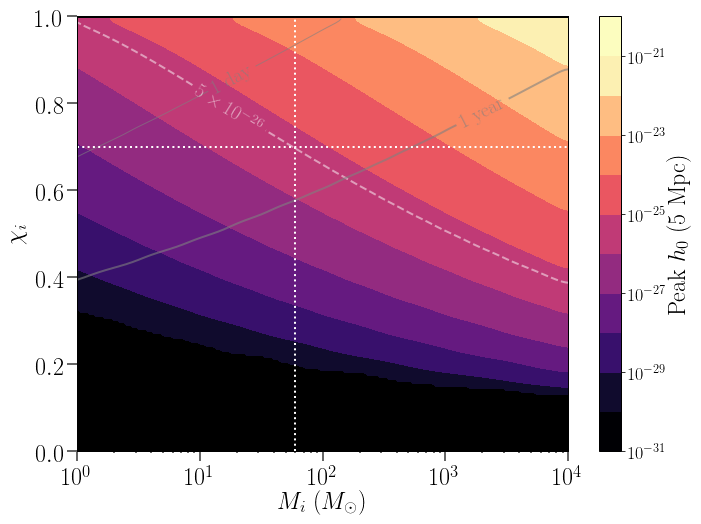

In [88]:
# contour plot for peak h0 vs chi vs M

h0s = df_max['h0']
hmax_ma = np.ma.masked_array(h0s, mask=((h0s<=1E-30) | (df_max['fgw']<0.01) | (df_max['fgw']>1E6)))

hmin, hmax = 1E-30, 1E-21
norm = matplotlib.colors.LogNorm(vmin=hmin, vmax=hmax)


X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
Z = hmax_ma.reshape(n_chi, n_mass)

## smooth the contours
from gwaxion import utilities
reload(utilities)
Z = utilities.smooth_data(Z, vmin=hmin)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
ax.set_xscale('log')
cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=8,base=10), norm=norm)

cs = ax.contour(X, Y, Z, colors=('white',), linestyles=('--',), linewidths=(2,), levels=[5E-26,], alpha=0.5)

strs = [r'$5\times10^{-26}$',]
fmt = {l: s for l, s in zip(cs.levels, strs)}
plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

# add Tinst contour
Ts = df_max['tinst']
tinsts_ma = np.ma.masked_array(Ts, mask=((h0s<=1E-30) | (df_max['fgw']<0.01) | (df_max['fgw']>1E6) | df_max['chi']<0.3))

Z = tinsts_ma.reshape(n_chi, n_mass)
Z = utilities.smooth_data(Z, vmin=physics.DAYSID_SI*0.5, vmax=physics.YRSID_SI*2)

day = physics.DAYSID_SI
yr = physics.YRSID_SI
cs = ax.contour(X, Y, Z, colors=('gray',), linestyles=('-',), linewidths=(1,2), levels=[day, yr], alpha=0.6)

strs = ['1 day', r'1 year']
fmt = {l: s for l, s in zip(cs.levels, strs)}
plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $h_0$ (5 Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi_i$')
plt.xlabel(r'$M_i$ $(M_\odot)$')
ax.patch.set_facecolor("black")

#plt.xlim(1, 1E4)
ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

fig.savefig('contour_chi_mbh_h0_DE.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

## Timescale

## Instability

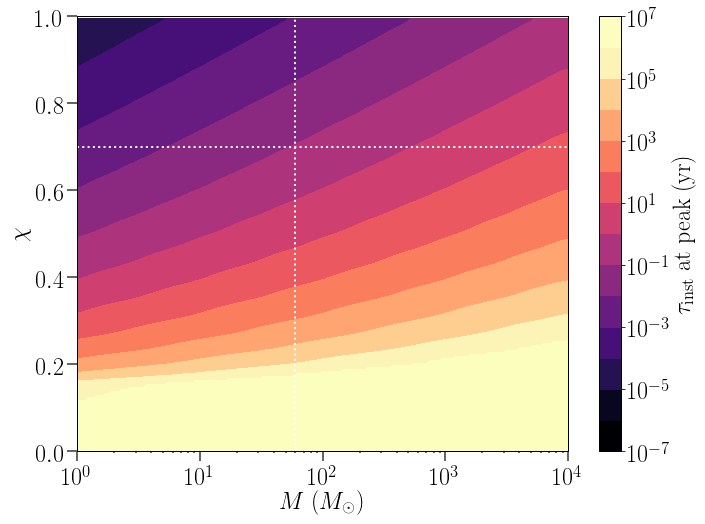

In [96]:
# colormap for peak h0 vs chi vs M

tinsts = df_max['tinst'] / physics.YRSID_SI
tinsts_ma = np.ma.masked_array(tinsts, mask=(h0s<=0))

X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
Z = tinsts_ma.reshape(n_chi, n_mass)

tmin, tmax = 1E-6, 1E6#tinsts_ma.max()
norm = matplotlib.colors.LogNorm(vmin=tmin, vmax=tmax)

fig, ax = plt.subplots(1, figsize=(11,8))

Z = utilities.smooth_data(Z, vmax=tmax)

# plot contours
# cm = ax.hexbin(df_cond['mbh'], df_cond['chi'], C=tinsts_ma, cmap='magma', norm=norm,  xscale='log')
# cm.set_rasterized(True)
cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=28,base=10), norm=norm)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm inst}$ at peak (yr)')#, ticks=cb_ticks)
#cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("#FCFEBD")

#plt.xlim(1, 1E4)
ax.set_xlim(1, 1E4)
ax.set_ylim(0, 1)
ax.set_xscale('log')

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)


fig.savefig('cmap_chi_mbh_tinst_DE.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

## Radiation

In [98]:
# colormap for peak h0 vs chi vs M

tgws = df_max['tgws'] / physics.YRSID_SI
tgws_ma = np.ma.masked_array(tgws, mask=(h0s<=0))

X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
Z = tinsts_ma.reshape(n_chi, n_mass)

tmin, tmax = 1E-6, 1E6#tinsts_ma.max()
norm = matplotlib.colors.LogNorm(vmin=tmin, vmax=tmax)

fig, ax = plt.subplots(1, figsize=(11,8))

Z = utilities.smooth_data(Z, vmax=tmax)

# plot contours
# cm = ax.hexbin(df_cond['mbh'], df_cond['chi'], C=tinsts_ma, cmap='magma', norm=norm,  xscale='log')
# cm.set_rasterized(True)
cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=28,base=10), norm=norm)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm GW}$ at peak (yr)')#, ticks=cb_ticks)
#cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("#FCFEBD")

#plt.xlim(1, 1E4)
ax.set_xlim(1, 1E4)
ax.set_ylim(0, 1)
ax.set_xscale('log')

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)


fig.savefig('cmap_chi_mbh_tgw_DE.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

KeyError: 'tgws'